In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# set batch size
batch_size = 100

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])), batch_size=batch_size, shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])), batch_size=batch_size, shuffle=True)

# set training epochs
training_epochs = 20

In [0]:
# define cnn architecture
class CNN_MNIST(nn.Module):
    
    def __init__(self):
        
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)        
        self.fc6 = nn.Linear(2*2*128, 100)
        self.fc7 = nn.Linear(100, 10)
    
    def forward(self, x):
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = out.view(-1, 2*2*128)
        out = F.relu(self.fc6(out))
        out = self.fc7(out)
        
        return F.log_softmax(out, dim=1)

In [0]:
# train and test model
def Q2_part_1():

  cnn = CNN_MNIST()
  cnn = cnn.cuda()
  
  optimizer = optim.Adam(cnn.parameters(), lr=0.001)

  train_accuracy_list = []
  test_accuracy_list = []
  
  for epoch in range(training_epochs):
    
    train_correct = 0
    test_correct = 0
    
    # training
    for idx, (data, label) in enumerate(train_loader):
      
      cnn.train()
      
      data = Variable(data)
      label = Variable(label)
      
      data = data.cuda()
      label = label.cuda()
      
      optimizer.zero_grad()
      logits = cnn(data)
      loss = F.nll_loss(logits, label)
      loss.backward()
      optimizer.step()
      
      _, pred = torch.max(logits.data, 1)
      train_correct += (pred==label).sum().item()
    
    # testing
    for idx, (data, label) in enumerate(test_loader):
      
      cnn.eval()
      
      data = Variable(data)
      label = Variable(label)
      
      data = data.cuda()
      label = label.cuda()
      
      with torch.no_grad():
        logits = cnn(data)
      
      _, pred = torch.max(logits.data, 1)
      test_correct += (pred==label).sum().item()
    
    train_accuracy = float(train_correct)/len(train_loader.dataset)
    train_accuracy_list.append(train_accuracy)
    
    test_accuracy = float(test_correct)/len(test_loader.dataset)
    test_accuracy_list.append(test_accuracy)
    
    if(epoch % 4 == 0):
      print("\nEpoch: ", epoch+1, ", Training Accuracy: ", train_accuracy, ", Test Accuracy: ", test_accuracy, "\n")
  
  print("\nFinal Test Accuracy: ", test_accuracy)
  
  return cnn, train_accuracy_list, test_accuracy_list


Epoch:  1 , Training Accuracy:  0.9250666666666667 , Test Accuracy:  0.9804 


Epoch:  5 , Training Accuracy:  0.9923 , Test Accuracy:  0.9882 


Epoch:  9 , Training Accuracy:  0.9948166666666667 , Test Accuracy:  0.9898 


Epoch:  13 , Training Accuracy:  0.9967166666666667 , Test Accuracy:  0.9896 


Epoch:  17 , Training Accuracy:  0.9975666666666667 , Test Accuracy:  0.9906 


Final Test Accuracy:  0.9884


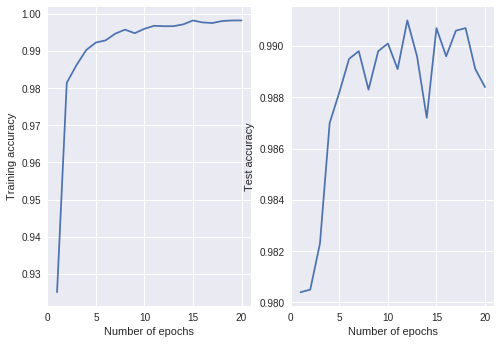

In [103]:
model, train_accuracy_list, test_accuracy_list = Q2_part_1() 

plt.subplot(1, 2, 1)        
plt.plot(np.arange(len(train_accuracy_list))+1, train_accuracy_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training accuracy")

plt.subplot(1, 2, 2)        
plt.plot(np.arange(len(test_accuracy_list))+1, test_accuracy_list)
plt.xlabel("Number of epochs")
plt.ylabel("Test accuracy")

plt.show()

In [0]:
test_loader_2 = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])), batch_size=1, shuffle=True)

In [0]:
# define untargeted fast gradient sign attack pertubations
def fgsm_untargeted(image, epsilon, data_grad):

	perturbed_image = image + epsilon*data_grad.sign()

	perturbed_image = torch.clamp(perturbed_image, -1.0, 1.0)

	return perturbed_image

In [0]:
# get adversarial images from untargeted FGSM attack
def adversarial_untargeted(model, test_loader, epsilon):
  
  model.eval()
  
  adversarials = []
  originals = []
  predictions = []
  confidences = []
  truths = []
  
  for data, label in test_loader:
    
    data = data.cuda()
    label = label.cuda()
    
    true_data = data.clone()
    
    out = model(data)
    _, pred = torch.max(out.data, 1)
    
    # generate adversarial images for correctly classified images
    if(pred.item() == label.item() and (len(adversarials) < 5)):
      
      prob = 0
      
      data.requires_grad = True
      
      while(prob < 0.9):
        
        out = model(data)
        
        loss = F.nll_loss(out, label)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_image = fgsm_untargeted(data, epsilon, data_grad)

        out2 = model(perturbed_image)

        _, pred2 = torch.max(out2.data, 1)

        confidence = F.softmax(out2, dim=1)[0][pred2].data.cpu().numpy()[0]
        
        prob = confidence
        
        data = Variable(perturbed_image, requires_grad=True)
        
        if((pred2.item() != label.item()) and (confidence >= 0.9)):
          adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
          originals.append(true_data.squeeze().detach().cpu().numpy())
          predictions.append(pred2.item())
          confidences.append(confidence.item())
          truths.append(label.item())
          break
          
      if(len(adversarials) == 10):
        break    
      
  return adversarials, originals, predictions, confidences, truths    

In [0]:
adversarials_1, originals_1, predictions_1, confidences_1, truths_1 = adversarial_untargeted(model, test_loader_2, 0.09)

In [117]:
# check first 3 adversarial images
for i in range(len(adversarials_1[:3])):
  print("Original image with label ", truths_1[i], " is predicted as ", predictions_1[i], " with confidence of ", confidences_1[i])

Original image with label  1  is predicted as  2  with confidence of  0.99997878074646
Original image with label  2  is predicted as  8  with confidence of  0.9185450673103333
Original image with label  6  is predicted as  8  with confidence of  0.9875827431678772


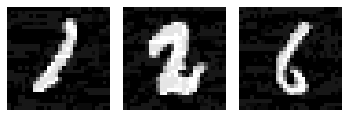

In [118]:
cnt = 0

plt.figure(figsize=(5,5))

for j in range(len(adversarials_1[:3])):
  cnt += 1
  plt.subplot(2,len(adversarials_1[:3]),cnt)
  plt.xticks([], [])
  plt.yticks([], [])
  ex = adversarials_1[j]
  plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [0]:
# define targeted fast gradient sign attack pertubations
def fgsm_targeted(image, epsilon, data_grad):

	perturbed_image = image - epsilon*data_grad.sign()

	perturbed_image = torch.clamp(perturbed_image, -1.0, 1.0)

	return perturbed_image

In [0]:
# get adversarial images from targeted FGSM attack
def adversarial_targeted(model, test_loader, epsilon):
  
  model.eval()
  
  adversarials = []
  originals = []
  predictions = []
  confidences = []
  truths = []
  
  for data, label in test_loader:
    
    data = data.cuda()
    label = label.cuda()
    
    true_data = data.clone()
    
    target = Variable(torch.Tensor([7])).long()
    target = target.cuda()
    
    out = model(data)
    _, pred = torch.max(out.data, 1)
    
    # generate adversarial images for correctly classified images
    if((pred.item() == label.item()) and (label.item() != 7)):
      
      prob = 0
      
      data.requires_grad = True
      
      while(prob < 0.9):
        
        out = model(data)
        
        loss = F.nll_loss(out, target)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_image = fgsm_targeted(data, epsilon, data_grad)

        out2 = model(perturbed_image)

        _, pred2 = torch.max(out2.data, 1)

        confidence = F.softmax(out2, dim=1)[0][pred2].data.cpu().numpy()[0]
        
        prob = confidence
        
        data = Variable(perturbed_image, requires_grad=True)
        
        if((pred2.item() == target.item()) and confidence >= 0.9):
          adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
          originals.append(true_data.squeeze().detach().cpu().numpy())
          predictions.append(pred2.item())
          confidences.append(confidence.item())
          truths.append(label.item())
          
      if(len(adversarials) == 10):
        break    
      
  return adversarials, originals, predictions, confidences, truths    

In [0]:
adversarials_2, originals_2, predictions_2, confidences_2, truths_2 = adversarial_targeted(model, test_loader_2, 0.09)

In [123]:
# check first 3 adversarial images
for i in range(len(adversarials_1[:3])):
  print("Original image with label ", truths_2[i], " is predicted as ", predictions_2[i], " with confidence of ", confidences_2[i])

Original image with label  9  is predicted as  7  with confidence of  0.9871550798416138
Original image with label  2  is predicted as  7  with confidence of  0.9981378316879272
Original image with label  2  is predicted as  7  with confidence of  0.9910991787910461


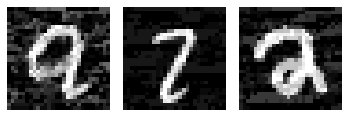

In [124]:
cnt = 0

plt.figure(figsize=(5,5))

for j in range(len(adversarials_2[:3])):
  cnt += 1
  plt.subplot(2,len(adversarials_2[:3]),cnt)
  plt.xticks([], [])
  plt.yticks([], [])
  ex = adversarials_2[j]
  plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()